In [1]:
import os 

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Generating the database from a BN

In [2]:
bn=gum.loadBN(os.path.join("res","asia.bif"))
bn

(gum::BayesNet<double>@0x5602e2eb9e50) BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 36, compression ratio: 85% }

In [3]:
# we create a quite large database
gum.generateCSV(bn,os.path.join("out","sample.csv"),500000,False)

-1612404.4796915192

# Testing d-separations using chi2 in the database

In [4]:
# do not forget that the generation process above is random : from time to time, the tests my not be correct...
def isIndep(pvalue):
    return pvalue>=0.05

def testIndepFromChi2(learner,var1,var2,kno=[]):
    """
    Just prints the resultat of the chi2
    """
    stat,pvalue=learner.chi2(var1,var2,kno)
    if len(kno)==0:
        print("From Chi2 tests, is '{}' indep from '{}' ==> {}".format(var1,var2,isIndep(pvalue)))
    else:
        print("From Chi2 tests, is '{}' indep from '{}' given {} : {}".format(var1,var2,kno,isIndep(pvalue)))
    
learner=gum.BNLearner(os.path.join("out","sample.csv"))

testIndepFromChi2(learner,"visit_to_Asia?","smoking?")
testIndepFromChi2(learner,"visit_to_Asia?","smoking?",['tuberculos_or_cancer?'])
testIndepFromChi2(learner,"visit_to_Asia?","smoking?",['positive_XraY?'])
testIndepFromChi2(learner,"dyspnoea?","smoking?")
testIndepFromChi2(learner,"dyspnoea?","smoking?",["lung_cancer?","bronchitis?"])


From Chi2 tests, is 'visit_to_Asia?' indep from 'smoking?' ==> True
From Chi2 tests, is 'visit_to_Asia?' indep from 'smoking?' given ['tuberculos_or_cancer?'] : False
From Chi2 tests, is 'visit_to_Asia?' indep from 'smoking?' given ['positive_XraY?'] : False
From Chi2 tests, is 'dyspnoea?' indep from 'smoking?' ==> False
From Chi2 tests, is 'dyspnoea?' indep from 'smoking?' given ['lung_cancer?', 'bronchitis?'] : True


# Evolution of chi2 p-values w.r.t the size of the database (in Asia)

In [62]:
def consolidationIndepFromChi2(bn,size,lindep,nbr=20):
    """
    Using $nbr$ generated databases of size $size$ from the bn $bn$, 
    consolidate the p-value for a list $lindep$ of conditional independence to test.
    
    return the list of consolidated pValues
    """
    pvalue_cumul=[0.0]*len(lindep)
    for i in range(nbr):
        gum.generateCSV(bn,os.path.join("out","sample.csv"),size,False)
        learner=gum.BNLearner(os.path.join("out","sample.csv"))
        for i,(var1,var2,kno) in enumerate(lindep):
            stat,pvalue=learner.chi2(var1,var2,kno)
            pvalue_cumul[i]+=pvalue
    return [p/nbr for p in pvalue_cumul]
    
sizes=[50,100,500,1000,2000,5000,10000,20000,50000,100000,200000]
pvalues1,pvalues2,pvalues3,pvalues4,pvalues5,pvalues6=zip(*[consolidationIndepFromChi2(bn,siz,
                                     [("visit_to_Asia?","smoking?",['tuberculos_or_cancer?']),
                                      ("visit_to_Asia?","smoking?",[]),
                                      ("dyspnoea?","smoking?",[]),
                                      ("dyspnoea?","smoking?",["lung_cancer?","bronchitis?"]),
                                      ("tuberculosis?","bronchitis?",[]),
                                      ("tuberculosis?","bronchitis?",["dyspnoea?"])])
                                          for siz in sizes])


(gum::BayesNet<double>@0x5602e8a93140) BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 36, compression ratio: 85% }

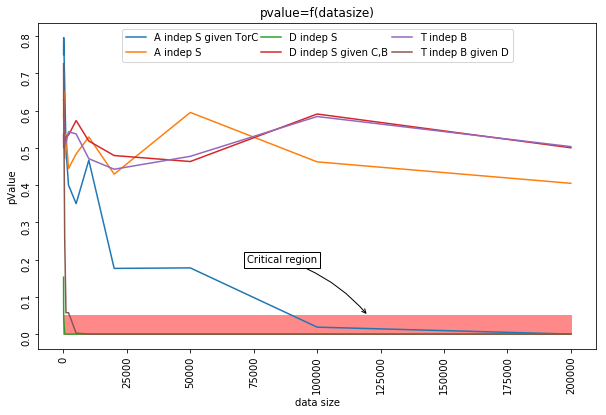

In [63]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)

ax.plot(sizes,pvalues1,label="A indep S given TorC")
ax.plot(sizes,pvalues2,label="A indep S")
ax.plot(sizes,pvalues3,label="D indep S")
ax.plot(sizes,pvalues4,label="D indep S given C,B")
ax.plot(sizes,pvalues5,label="T indep B")
ax.plot(sizes,pvalues6,label="T indep B given D")
ax.tick_params(rotation=90)
ax.set_xlabel("data size")
ax.set_ylabel("pValue")
ax.legend(bbox_to_anchor=(0.15, 0.88, 0.7, .102), loc=3,ncol=3, mode="expand", borderaxespad=0.)

rect = patches.Rectangle((0,0),max(sizes),0.05,linewidth=1,edgecolor='#FF8888',facecolor='#FF8888')
ax.add_patch(rect)
ax.annotate("Critical region",xytext=(100000,0.2),xy=(120000,0.05),
            ha="right", va="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.15"
                           ),
            bbox=dict(boxstyle="square", fc="w"))

ax.set_title("pvalue=f(datasize)");

gum.fastBN("A->T->TorC->X;S->C->TorC->D<-B<-S")

# Conditional joint log-likelihood
With BNLearner, you can also check the joint (condtional) log-likelihood in the base

In [37]:
bn

(gum::BayesNet<double>@0x5602e2eb9e50) BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 36, compression ratio: 85% }

In [38]:
siz=10000
gum.generateCSV(bn,os.path.join("out","sample.csv"),siz,False)
learner=gum.BNLearner(os.path.join("out","sample.csv"))

def affLL(learner,s1,s2=[]):
    if len(s2)==0:
        print("{} : {}".format(s1,learner.logLikelihood(s1)))
    else:
        print("{}|{} : {}".format(s1,s2,learner.logLikelihood(s1,s2)))
        
def dsepByLL(learner,x,y,z): # is X indep of Y given Z ?
    lxy_z=learner.logLikelihood([x,y],[z])
    lx_z=learner.logLikelihood([x],[z])
    ly_z=learner.logLikelihood([y],[z])
    print("{} indep {} given {} : {}".format(x,y,z,lxy_z-lx_z-ly_z))

print("Condional Joint LogLikelihood")
affLL(learner,["lung_cancer?","bronchitis?","smoking?"])
affLL(learner,["smoking?"])
affLL(learner,["lung_cancer?","bronchitis?"],["smoking?"])

print("--------------")
print("LL indep test")
dsepByLL(learner,"lung_cancer?","bronchitis?","smoking?")
dsepByLL(learner,"tuberculos_or_cancer?","bronchitis?","dyspnoea?")

Condional Joint LogLikelihood
['lung_cancer?', 'bronchitis?', 'smoking?'] : -22080.525365426085
['smoking?'] : -9999.99740314877
['lung_cancer?', 'bronchitis?']|['smoking?'] : -12080.527962277314
--------------
LL indep test
lung_cancer? indep bronchitis? given smoking? : 3.8099889241839264
tuberculos_or_cancer? indep bronchitis? given dyspnoea? : 121.2250829097793


# Evolution of conditional log-likelihood w.r.t the size of the database (in Asia)

In [49]:
def consolidationIndepFromLL(bn,size,lindep,nbr=20):
    """
    Using $nbr$ generated databases of size $size$ from the bn $bn$, 
    consolidate the logLikelihoos for a list $lindep$ of conditional independence to test.
    
    return the list of consolidated pValues
    """
    LL_cumul=[0.0]*len(lindep)
    for i in range(nbr):
        gum.generateCSV(bn,os.path.join("out","sample.csv"),size,False)
        learner=gum.BNLearner(os.path.join("out","sample.csv"))
        for i,(var1,var2,kno) in enumerate(lindep):
            LL12=learner.logLikelihood([var1,var2],kno)
            LL1=learner.logLikelihood([var1],kno)
            LL2=learner.logLikelihood([var2],kno)
            LL_cumul[i]+=(LL12-LL1-LL2)/size
    return [p/nbr for p in LL_cumul]
    
sizes=[50,100,500,1000,2000,5000,10000,20000,50000,100000,200000]
LL1,LL2,LL3,LL4,LL5,LL6=zip(*[consolidationIndepFromLL(bn,siz,
                                     [("visit_to_Asia?","smoking?",['tuberculos_or_cancer?']),
                                      ("visit_to_Asia?","smoking?",[]),
                                      ("dyspnoea?","smoking?",[]),
                                      ("dyspnoea?","smoking?",["lung_cancer?","bronchitis?"]),
                                      ("tuberculosis?","bronchitis?",[]),
                                      ("tuberculosis?","bronchitis?",["dyspnoea?"])])
                                          for siz in sizes])




(gum::BayesNet<double>@0x5602e54e6fa0) BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 36, compression ratio: 85% }

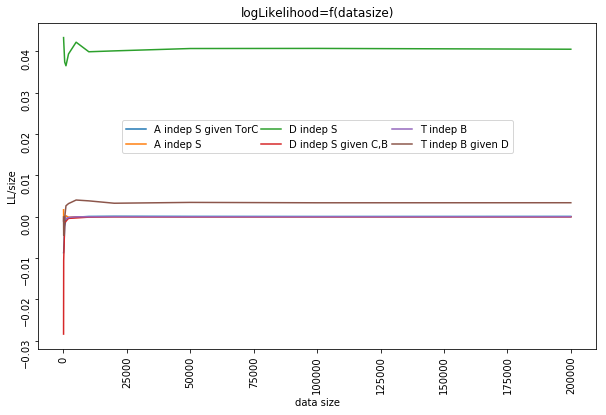

In [54]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)

ax.plot(sizes,LL1,label="A indep S given TorC")
ax.plot(sizes,LL2,label="A indep S")
ax.plot(sizes,LL3,label="D indep S")
ax.plot(sizes,LL4,label="D indep S given C,B")
ax.plot(sizes,LL5,label="T indep B")
ax.plot(sizes,LL6,label="T indep B given D")
ax.tick_params(rotation=90)
ax.set_xlabel("data size")
ax.set_ylabel("LL/size")
ax.legend(bbox_to_anchor=(0.15, 0.6, 0.7, .102), loc=3,ncol=3, mode="expand", borderaxespad=0.)

ax.set_title("logLikelihood=f(datasize)");

gum.fastBN("A->T->TorC->X;S->C->TorC->D<-B<-S")